In [65]:
import pandas as pd


data = pd.read_csv(r'F:\FYP\pythonProject1\dataset\BCICIV_2a_all_patients.csv')

In [66]:
# Check the first few rows
print(data.head())

# Check column names
print(data.columns)

# Check for missing values
print(data.isnull().sum())

# Display basic statistics of the dataset
print(data.describe())

   patient   time   label  epoch    EEG-Fz     EEG-0     EEG-1     EEG-2  \
0        1 -0.100  tongue      8 -1.681412  2.245496 -0.158350  1.163765   
1        1 -0.096  tongue      8  0.420417  0.587559  1.650510  0.970672   
2        1 -0.092  tongue      8  0.551365  1.499758  0.121302  2.859433   
3        1 -0.088  tongue      8  3.054916 -1.807238  1.843603  2.286812   
4        1 -0.084  tongue      8  2.506710 -2.453101  0.221178  0.127278   

      EEG-3     EEG-4  ...     EEG-8     EEG-9    EEG-10    EEG-11    EEG-12  \
0 -1.523659 -0.575267  ...  0.758116  3.441785  0.305517  1.137473 -1.275763   
1  1.505904  0.891796  ...  1.541586 -0.071620  0.258909 -1.448198  0.142472   
2  2.613414  4.636026  ...  2.649097 -2.137938 -1.612096 -1.610218 -0.410173   
3  5.995872  6.651295  ...  6.031554 -5.249621 -2.672998 -3.452370  0.189081   
4  4.519931  6.249573  ...  7.827097 -5.309546 -2.488783 -3.707608  1.447515   

     EEG-13    EEG-14    EEG-Pz    EEG-15    EEG-16  
0 -2.898

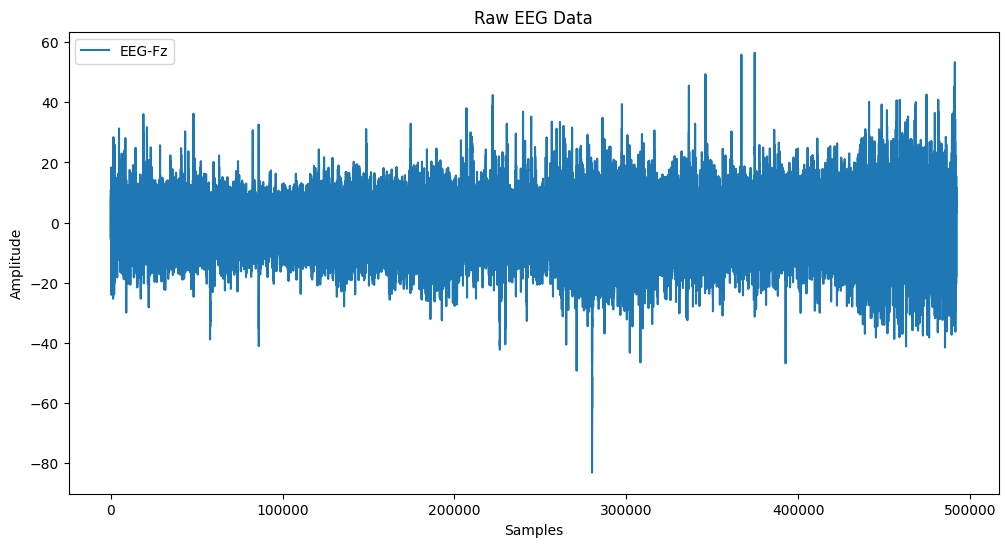

In [68]:
import matplotlib.pyplot as plt

# Visualize the raw EEG data for a specific channel (e.g., 'EEG-Fz')
plt.figure(figsize=(12, 6))
plt.plot(data['EEG-Fz'], label='EEG-Fz')
plt.title('Raw EEG Data')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [71]:

from scipy.signal import butter, filtfilt

# Band-pass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    # Apply zero-phase filtering
    return filtfilt(b, a, data)

# Define parameters for filtering
fs = 250  # Sampling frequency in Hz
lowcut = 0.5  # Low cut-off frequency in Hz
highcut = 50.0  # High cut-off frequency in Hz

# Filter the EEG data
data['EEG-Fz_filtered'] = bandpass_filter(data['EEG-Fz'].values, lowcut, highcut, fs)

# Display the first few rows of the filtered data
print(data[['EEG-Fz', 'EEG-Fz_filtered']].head())


     EEG-Fz  EEG-Fz_filtered
0 -1.681412        -1.625415
1  0.420417        -0.020500
2  0.551365         1.526709
3  3.054916         2.575571
4  2.506710         2.500676


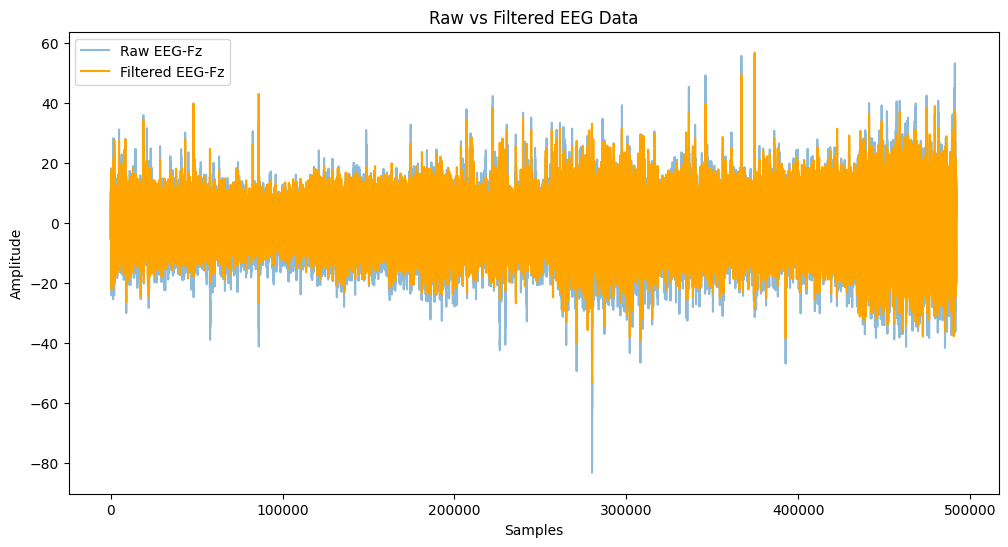

In [72]:
# Visualize the raw and filtered EEG data
plt.figure(figsize=(12, 6))
plt.plot(data['EEG-Fz'], label='Raw EEG-Fz', alpha=0.5)
plt.plot(data['EEG-Fz_filtered'], label='Filtered EEG-Fz', color='orange')
plt.title('Raw vs Filtered EEG Data')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [73]:
data.to_csv('filtered_eeg_data.csv', index=False)


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, welch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [76]:
def remove_artifacts(data, threshold=100):
    """ Remove segments with artifacts based on a threshold. """
    data_filtered = np.where(np.abs(data) > threshold, np.nan, data)
    return pd.Series(data_filtered).interpolate(method='linear')

data['EEG-Fz_filtered'] = remove_artifacts(data['EEG-Fz_filtered'])

In [77]:
# Segmentation
epoch_length = 2  # Length of each epoch in seconds
n_samples = fs * epoch_length  # Number of samples in each epoch
epochs = []

for start in range(0, len(data['EEG-Fz_filtered']), n_samples):
    end = start + n_samples
    epoch = data['EEG-Fz_filtered'].values[start:end]
    if len(epoch) == n_samples:  # Ensure the epoch is complete
        epochs.append(epoch)

# Convert epochs to a DataFrame for further analysis
epochs_df = pd.DataFrame(epochs)

In [78]:
# Feature Extraction - Power Spectral Density (PSD)
def compute_psd(data, fs):
    f, Pxx = welch(data, fs, nperseg=fs)
    return f, Pxx
# Compute PSD for each epoch
psd_results = []
for epoch in epochs:
    f, Pxx = compute_psd(epoch, fs)
    psd_results.append(Pxx)

# Convert psd_results to a DataFrame for easy handling
psd_df = pd.DataFrame(psd_results)

In [ ]:
# Compute PSD for each epoch
psd_results = []
for epoch in epochs:
    f, Pxx = compute_psd(epoch, fs)
    psd_results.append(Pxx)

# Convert psd_results to a DataFrame for easy handling
psd_df = pd.DataFrame(psd_results)

# Save PSD results
psd_df.to_csv('psd_results.csv', index=False)

                 mean       std   count
Condition                              
Condition_A -0.008603  6.484819  246103
Condition_B  0.009025  6.477916  245945


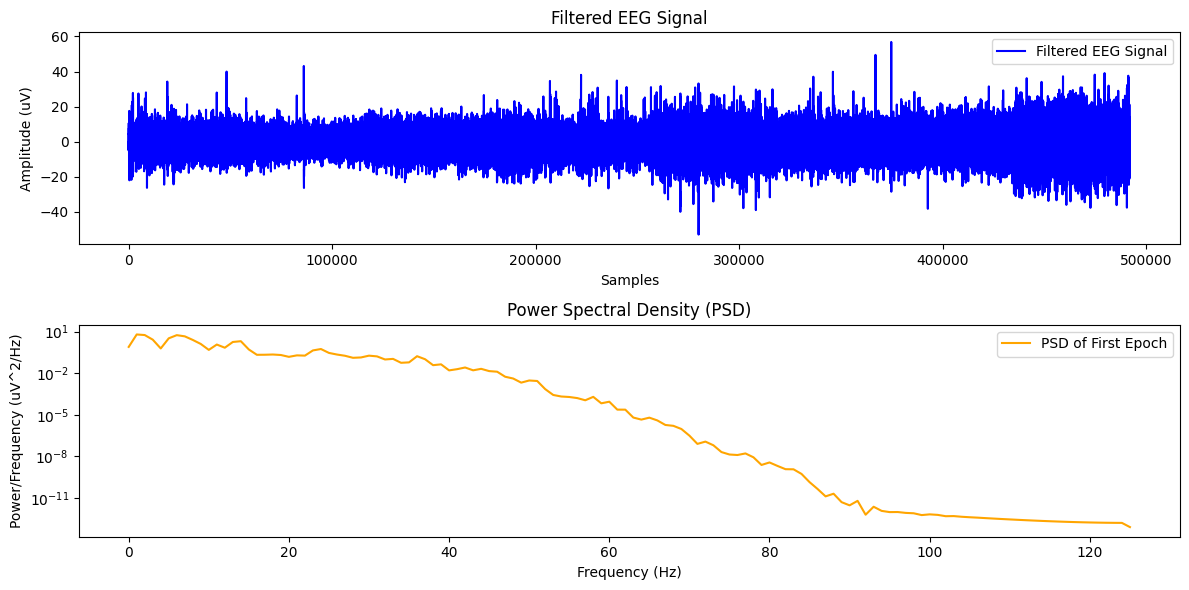

              precision    recall  f1-score   support

 Condition_A       0.46      0.65      0.54       134
 Condition_B       0.56      0.37      0.45       162

    accuracy                           0.50       296
   macro avg       0.51      0.51      0.49       296
weighted avg       0.52      0.50      0.49       296

[[ 87  47]
 [102  60]]


In [81]:
# Step 7: Analyze the Data

# Statistical Analysis (Example: comparing means of two conditions)
# Assuming you have two conditions: 'Condition_A' and 'Condition_B'
# For demonstration, we'll generate random labels
data['Condition'] = np.random.choice(['Condition_A', 'Condition_B'], size=len(data))

# Group data by condition
grouped_data = data.groupby('Condition')['EEG-Fz_filtered'].agg(['mean', 'std', 'count'])

print(grouped_data)

# Visualization - Power Spectral Density plot of the first epoch
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(data['EEG-Fz_filtered'], label='Filtered EEG Signal', color='blue')
plt.title('Filtered EEG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude (uV)')
plt.legend()

plt.subplot(2, 1, 2)
plt.semilogy(f, psd_results[0], label='PSD of First Epoch', color='orange')
plt.title('Power Spectral Density (PSD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (uV^2/Hz)')
plt.legend()

plt.tight_layout()
plt.show()

# Machine Learning Example - Train a classifier
# Prepare features and labels
X = psd_df  # Use PSD results as features
y = data['Condition'].dropna().values[:len(X)]  # Use the condition labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [82]:
import numpy as np
import pandas as pd

# Load your filtered EEG data (replace 'filtered_eeg_data.csv' with your actual file name)
data_filtered = pd.read_csv('filtered_eeg_data.csv')
print(data_filtered.head())

   patient   time   label  epoch    EEG-Fz     EEG-0     EEG-1     EEG-2  \
0        1 -0.100  tongue      8 -1.681412  2.245496 -0.158350  1.163765   
1        1 -0.096  tongue      8  0.420417  0.587559  1.650510  0.970672   
2        1 -0.092  tongue      8  0.551365  1.499758  0.121302  2.859433   
3        1 -0.088  tongue      8  3.054916 -1.807238  1.843603  2.286812   
4        1 -0.084  tongue      8  2.506710 -2.453101  0.221178  0.127278   

      EEG-3     EEG-4  ...     EEG-9    EEG-10    EEG-11    EEG-12    EEG-13  \
0 -1.523659 -0.575267  ...  3.441785  0.305517  1.137473 -1.275763 -2.898359   
1  1.505904  0.891796  ... -0.071620  0.258909 -1.448198  0.142472 -1.968405   
2  2.613414  4.636026  ... -2.137938 -1.612096 -1.610218 -0.410173 -0.274957   
3  5.995872  6.651295  ... -5.249621 -2.672998 -3.452370  0.189081  1.593829   
4  4.519931  6.249573  ... -5.309546 -2.488783 -3.707608  1.447515  4.268278   

     EEG-14    EEG-Pz    EEG-15    EEG-16  EEG-Fz_filtered  
0

In [83]:
print(data_filtered.columns)


Index(['patient', 'time', 'label', 'epoch', 'EEG-Fz', 'EEG-0', 'EEG-1',
       'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz',
       'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12',
       'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16', 'EEG-Fz_filtered'],
      dtype='object')


In [84]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical  # Ensure this import is included
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
from keras.optimizers import Adam

In [85]:
# Load your filtered EEG data
data_filtered = pd.read_csv('filtered_eeg_data.csv')

# Prepare the data
time_steps = 128  # Number of time steps in each sample
selected_columns = ['EEG-Fz', 'EEG-C3', 'EEG-Cz', 'EEG-C4', 'EEG-Pz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 
                    'EEG-5', 'EEG-6', 'EEG-7', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 
                    'EEG-14', 'EEG-15', 'EEG-16']  # Include all available EEG channels

# Update num_channels based on the number of selected channels
num_channels = len(selected_columns)  # Update this to the number of channels you choose

# Check if there's enough data
total_samples = len(data_filtered)  # Total number of samples in the data
if total_samples < time_steps * num_channels:
    raise ValueError("Not enough data to reshape. Ensure your dataset is large enough.")

# Calculate the number of samples that can be created
num_samples = total_samples // (time_steps)  # Calculate the number of complete samples you can create

# Reshape the filtered EEG data
X = data_filtered[selected_columns].values
X_reshaped = np.zeros((num_samples, time_steps, num_channels))  # Preallocate the reshaped array

for i in range(num_samples):
    start_index = i * time_steps
    X_reshaped[i] = X[start_index:start_index + time_steps]

# Prepare the labels
y = data_filtered['label'].values[:num_samples]
y_encoded = pd.factorize(y)[0]  # Encode labels to integers
num_classes = len(pd.unique(y_encoded))  # Number of unique labels
y_reshaped = to_categorical(y_encoded, num_classes)  # One-hot encode labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.2, random_state=42)

In [86]:
# Step 2: Build the 2D CNN-LSTM Model
# Reshape input for CNN-LSTM model
X_train_cnn_lstm = X_train.reshape(X_train.shape[0], time_steps, num_channels, 1)  # Add channel dimension
X_test_cnn_lstm = X_test.reshape(X_test.shape[0], time_steps, num_channels, 1)  # Add channel dimension


In [87]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dropout, Dense, TimeDistributed, Reshape, Input


In [88]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Reshape, LSTM, Dropout, Dense, Input

# Initialize the model
model = Sequential()

# Input Layer: Ensure the input shape is correct for 2D CNN
model.add(Input(shape=(time_steps, num_channels, 1)))

# Convolutional Layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Reshape the output to fit LSTM input
model.add(Reshape((-1, 30 * 4 * 64)))  # Reshape to match your output shape

# Add LSTM Layer
model.add(LSTM(50, return_sequences=False))  # Using LSTM for temporal features

# Dropout Layer for regularization
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))  # Output layer for classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 126, 20, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 63, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 61, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 1, 7680)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │     1,546,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,565,220 (5.97 MB)

 Trainable params: 1,565,220 (5.97 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
import tensorflow as tf

# Set memory growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Now train your model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=32)



Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.2599 - loss: 1.4564 - val_accuracy: 0.3433 - val_loss: 1.3575
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.3229 - loss: 1.3957 - val_accuracy: 0.2679 - val_loss: 1.3631
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.3316 - loss: 1.3810 - val_accuracy: 0.3433 - val_loss: 1.3573
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3153 - loss: 1.3745 - val_accuracy: 0.3433 - val_loss: 1.3587
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.3636 - loss: 1.3533 - val_accuracy: 0.3433 - val_loss: 1.3568
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3659 - loss: 1.3469 - val_accuracy: 0.3433 - val_loss: 1.3570
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3423 - loss: 1.3694 - val_accuracy: 0.3433 - val_loss: 1.3591
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3877 - loss: 1.3442 - val_accuracy: 0.3433 - v

In [91]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3351 - loss: 1.3599
Test Loss: 1.3573, Test Accuracy: 0.3433


In [92]:

# Convert accuracy to percentage
train_accuracy = history.history['accuracy']  # Training accuracy in fractions
val_accuracy = history.history['val_accuracy']  # Validation accuracy in fractions

# Convert to percentage
train_accuracy_percentage = [acc * 100 for acc in train_accuracy]
val_accuracy_percentage = [acc * 100 for acc in val_accuracy]

# Print accuracy in percentage
print("Training Accuracy (%):", train_accuracy_percentage)
print("Validation Accuracy (%):", val_accuracy_percentage)


Training Accuracy (%): [27.5772362947464, 32.227641344070435, 34.04878079891205, 33.691057562828064, 35.64227521419525, 36.19512319564819, 36.422765254974365, 37.95121908187866, 37.95121908187866, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 38.01625967025757, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.983739376068115, 37.9

In [93]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Convert to percentage
test_accuracy_percentage = test_accuracy * 100

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy_percentage:.2f}%")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3351 - loss: 1.3599
Test Accuracy: 34.33%


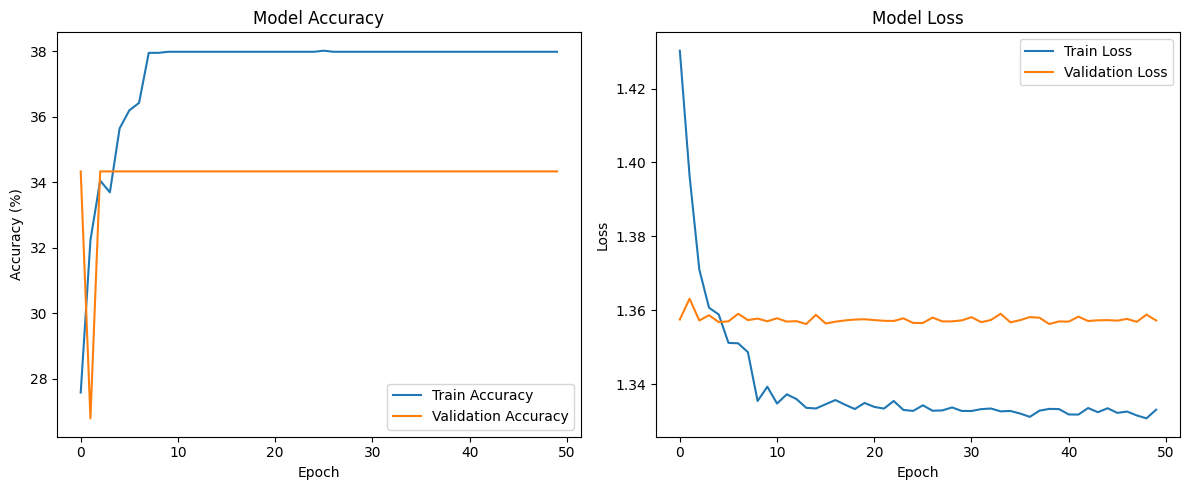

In [94]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_percentage, label='Train Accuracy')
plt.plot(val_accuracy_percentage, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()
